In [1]:
import os, time, random
import numpy as np
import pandas as pd
import cv2, torch
from tqdm.auto import tqdm
import shutil as sh

from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%time

!git clone https://github.com/ultralytics/yolov3  # clone repo
!pip install -U pycocotools
!pip install -qr yolov3/requirements.txt  # install dependencies
!cp yolov3/requirements.txt ./

Cloning into 'yolov3'...
remote: Enumerating objects: 10065, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 10065 (delta 21), reused 28 (delta 13), pack-reused 10017
Receiving objects: 100% (10065/10065), 9.38 MiB | 28.59 MiB/s, done.
Resolving deltas: 100% (6780/6780), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 14.1 MB/s 
CPU times: user 102 ms, sys: 50.1 ms, total: 152 ms
Wall time: 10.9 s


In [4]:
img_h, img_w, num_channels = (380, 676, 3)
df = pd.read_csv('/content/drive/MyDrive/MIS515-Object_Detection_Project/Project/car-object-detection/data/train_solution_bounding_boxes (1).csv')
df.rename(columns={'image':'image_id'}, inplace=True)
df['image_id'] = df['image_id'].apply(lambda x: x.split('.')[0])
df['x_center'] = (df['xmin'] + df['xmax'])/2
df['y_center'] = (df['ymin'] + df['ymax'])/2
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']
df['classes'] = 0
df['x_center'] = df['x_center']/img_w
df['w'] = df['w']/img_w
df['y_center'] = df['y_center']/img_h
df['h'] = df['h']/img_h
df.head()

,image_id,xmin,ymin,xmax,ymax,x_center,y_center,w,h,classes
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547,0.450434,0.539817,0.068741,0.095238,0
1,vid_4_10000,15.163531,187.035071,120.329957,236.430180,0.100217,0.557191,0.155572,0.129987,0
2,vid_4_10040,239.192475,176.764801,361.968162,236.430180,0.444645,0.543678,0.181621,0.157014,0
3,vid_4_10020,496.483358,172.363256,630.020260,231.539575,0.833213,0.531451,0.197540,0.155727,0
4,vid_4_10060,16.630970,186.546010,132.558611,238.386422,0.110347,0.559122,0.171491,0.136422,0


index = list(set(df.image_id))
image = random.choice(index)
print("Image ID: %s"%(image))
img = cv2.imread(f'/content/drive/MyDrive/TUM/assigenment2/car-object-detection/data/training_images/{image}.jpg')
img.shape

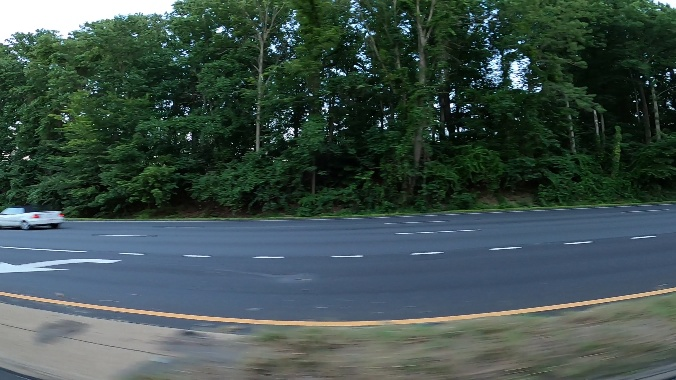

In [5]:
index = list(set(df.image_id))
image = random.choice(index)
Image(filename=f'/content/drive/MyDrive/MIS515-Object_Detection_Project/Project/car-object-detection/data/training_images/{image}.jpg',width=600)

In [6]:
#Training
source = 'training_images'
if True:
    for fold in [0]:
        val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
        for name,mini in tqdm(df.groupby('image_id')):
            if name in val_index:
                path2save = 'val2017/'
            else:
                path2save = 'train2017/'
            if not os.path.exists('/content/tmp/convertor/fold{}/labels/'.format(fold)+path2save):
                os.makedirs('/content/tmp/convertor/fold{}/labels/'.format(fold)+path2save)
            with open('/content/tmp/convertor/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
                row = mini[['classes','x_center','y_center','w','h']].astype(float).values
                row = row.astype(str)
                for j in range(len(row)):
                    text = ' '.join(row[j])
                    f.write(text)
                    f.write("\n")
            if not os.path.exists('/content/tmp/convertor/fold{}/images/{}'.format(fold,path2save)):
                os.makedirs('/content/tmp/convertor/fold{}/images/{}'.format(fold,path2save))
            sh.copy("/content/drive/MyDrive/MIS515-Object_Detection_Project/Project/car-object-detection/data/{}/{}.jpg".format(source,name),'/content/tmp/convertor/fold{}/images/{}/{}.jpg'.format(fold,path2save,name))


  0%|          | 0/355 [00:00<?, ?it/s]

In [7]:
###car.yaml example: (not run)

# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
#path: ../datasets/coco128  # dataset root dir
#train: images/train2017  # train images (relative to 'path') 128 images
#val: images/train2017  # val images (relative to 'path') 128 images
#test:  # test images (optional)

# Classes
nc: 80  # number of classes
names: [ 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
         'hair drier', 'toothbrush' ]  # class names

In [8]:
# running the training procedure
!python /content/yolov3/train.py --batch 4 --epochs 30 --data /content/drive/MyDrive/MIS515-Object_Detection_Project/Project/car.yaml --cfg /content/yolov3/models/yolov3.yaml
# once the training is done, your weights will be stored in 'yolov3/runs/train/exp' (googlecolab page on the left)

train: weights=yolov3/yolov3.pt, cfg=/content/yolov3/models/yolov3.yaml, data=/content/drive/MyDrive/MIS515-Object_Detection_Project/Project/car.yaml, hyp=yolov3/data/hyps/hyp.scratch.yaml, epochs=30, batch_size=4, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=yolov3/runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov3 ✅
YOLOv3 🚀 v9.6.0-29-ga441ab1 torch 1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_

In [9]:
!python yolov3/detect.py --weights /content/yolov3/runs/train/exp/weights/best.pt --conf 0.3 --source /content/drive/MyDrive/MIS515-Object_Detection_Project/Project/Police_Car.mp4
# "yolo" RuntimeError: Given groups=1, weight of size expected input -> train.py https://blog.csdn.net/qq_43533724/article/details/121743384

detect: weights=['/content/yolov3/runs/train/exp/weights/best.pt'], source=/content/drive/MyDrive/MIS515-Object_Detection_Project/Project/Police_Car.mp4, imgsz=[640, 640], conf_thres=0.3, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov3/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv3 🚀 v9.6.0-29-ga441ab1 torch 1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model Summary: 261 layers, 61497430 parameters, 0 gradients, 154.5 GFLOPs
video 1/1 (1/764) /content/drive/MyDrive/MIS515-Object_Detection_Project/Project/Police_Car.mp4: 480x640 7 cars, Done. (0.054s)
video 1/1 (2/764) /content/drive/MyDrive/MIS515-Object_Detection_Project/Project/Police_Car.mp4: 480x640 7 cars, Done. (0.040s)
video 1/1 (3/764) /content/drive/MyDrive/MIS515-Object_Dete

In [10]:
# not a must to run here, you can download the processed video/image from 'yolov3/runs/detect/exp'
# below is just a display code for mp4 on googlecolab
#Takes a long time to process video here
#from IPython.display import HTML
#from base64 import b64encode
 
#def show_video(video_path, video_width = 600):
   
  #video_file = open(video_path, "r+b").read()
 
  #video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  #return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

#video_path = "/content/yolov3/runs/detect/exp2/160820_052_NYC_TaxisInRain2_1080p.mp4"
#show_video(video_path)